In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [163]:
user = pd.read_csv('user_table.csv')
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [164]:
df = pd.read_csv('test_table.csv')
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [165]:
###---Join two tables
print ("There is no duplicates in test table: ", df['user_id'].nunique() == df.shape[0])
print('\n')
print ("There is no  duplicates in user table: ", user['user_id'].nunique() == user.shape[0])

There is no duplicates in test table:  True


There is no  duplicates in user table:  True


In [166]:
# check if everyone in one table also in other one?
df['user_id'].nunique()-user['user_id'].nunique()

## looks like user table has some user ids missing. when joining, 
## we have to be careful to do not lose the user ids in the test table, but not in the user table

454

In [167]:
data = df.merge(user, on='user_id',how='left')

In [168]:
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [169]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
user_id,453321.0,499937.514728,288665.193436,1.0,249816.0,500019.0,749522.0,1000000.0
conversion,453321.0,0.049579,0.217073,0.0,0.0,0.0,0.0,1.0
test,453321.0,0.476446,0.499445,0.0,0.0,0.0,1.0,1.0
age,452867.0,27.130740,6.776678,18.0,22.0,26.0,31.0,70.0


In [170]:
groupby_country = data[data['test']==0].groupby('country')['conversion'].mean()  ##test=0 is control group

In [171]:
groupby_country = groupby_country.reset_index().sort_values('conversion', ascending=False)

In [172]:
groupby_country

## it looks like spain covert at least 2% more than the rest of LatAm countries.

,country,conversion
14,Spain,0.079719
6,El Salvador,0.053554
10,Nicaragua,0.052647
4,Costa Rica,0.052256
3,Colombia,0.052089
8,Honduras,0.050906
7,Guatemala,0.050643
16,Venezuela,0.050344
13,Peru,0.049914
9,Mexico,0.049495


<AxesSubplot:xlabel='country', ylabel='conversion'>

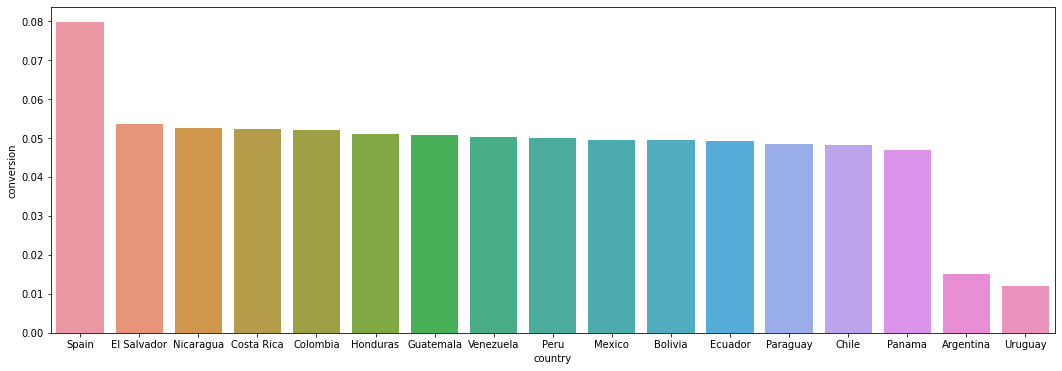

In [173]:
fig = plt.figure(figsize=(18,6))
sns.barplot(x='country',y='conversion', data=groupby_country)

<AxesSubplot:xlabel='country', ylabel='conversion'>

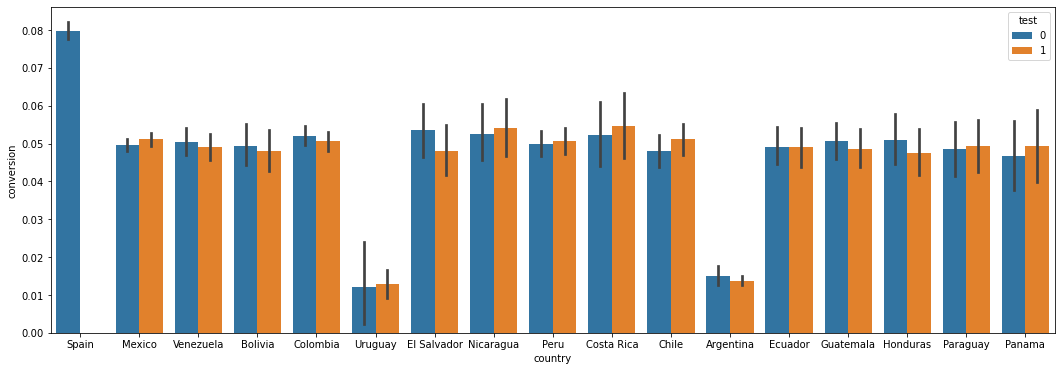

In [174]:
fig = plt.figure(figsize=(18, 6))
sns.barplot(x='country', y='conversion', hue='test', data=data)

In [175]:
#========================================================
# A/B TEST
#========================================================
test_data = data[data['country']!='Spain']
orig = test_data[test_data['test']==0]['conversion'].values
after = test_data[test_data['test']==1]['conversion'].values

In [176]:
print("Mean conversion rate of control group:", orig.mean())
print("Mean conversion rate of test group:", after.mean())
## in control group: the conversion rate is 4.8%, while in test group, the conversion rate is 4.3%((4.8%-4.3%)/4.8%) . This is a 10% drop
## which would be dramatic if it were true. 

Mean conversion rate of control group: 0.04833042316066309
Mean conversion rate of test group: 0.043424713982118966


In [177]:
###  Welch's t-test --unequal variances independent samples t-test
# 1 check the assumption of normality using the stats.shapiro()
from scipy.stats import shapiro
print(shapiro(orig))
print(shapiro(after))

# Neither of the variables of interest violates the assumption of normality so we can continue with our analysis plan.

ShapiroResult(statistic=0.21902984380722046, pvalue=0.0)
ShapiroResult(statistic=0.20420461893081665, pvalue=0.0)


C:\Users\yijia\anaconda3\envs\py3-TF2.0\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [178]:
from scipy.stats import ttest_ind
ttest_ind(orig, after, equal_var=False)
#statistic=7.3939374121344805, pvalue=1.4282994754055316e-13
# Thus we reject H0, and conclude that there is a significant difference between the two sample's mean

Ttest_indResult(statistic=7.3939374121344805, pvalue=1.4282994754055316e-13)

The most likely reason for weird A/B test results are:
1. we didn't collect enough data
2. Some bias has been introduced in the experiment so that test/control people are not really random.

In data science, whenever results appear too bad or too good to be true, they are not true.

In [179]:
orig_bydate = test_data[test_data['test']==0][['date','conversion']].groupby('date').mean()
after_bydate = test_data[test_data['test']==1][['date','conversion']].groupby('date').mean()

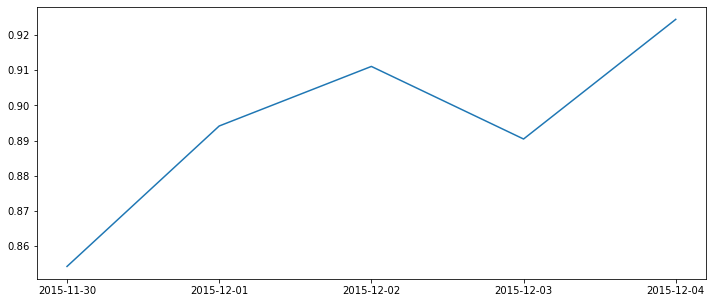

In [180]:
fig = plt.figure(figsize=(12,5))
plt.plot(after_bydate/orig_bydate)

From the above plot, we notice:
1. Test has constantly been worse than control and there is relatively little variance across days. That probably means that we do have enough data, but there was some bias in the experiment set up.
2. On a side note, we just ran it for 5 days. We should always run the test for at least 1 full week to capture weekly patterns, 2 weeks should be much better. 

Time to find out the bias! Likely, there is for some reason some segment of users more likely to end up in test or in control. There are many ways to check this, One way is to build a decision tree where the variables are the user dimensions and the outcome variable is whether the user is in test or control. If the tree splits, it means that for given values of that varibale you are more likely to end up in test or control. But this should be impossible! Therefore, if the randomization worked, the tree should not split at all (or at least not be able to separate the two classes well)

In [181]:
# One-Hot-Encoding for Categorical Data
def OneHotEncoding(d):
    col_name = d.columns
    for i in range(d.shape[1]):
        dummy = pd.get_dummies(d[col_name[i]], prefix=col_name[i], drop_first=True)
        d = pd.concat([d, dummy], axis=1)
        d = d.drop(col_name[i], axis=1)
    return d

def DataTransformation(data):
    cat = data.select_dtypes(include = ['object'])
    cat_new = OneHotEncoding(cat)
    newdata = pd.concat([data.drop(cat,axis=1), cat_new], axis=1)
    return newdata

In [182]:
print(pd.concat([test_data.isnull().sum(), test_data.isnull().sum()/len(test_data)], axis=1))

                       0         1
user_id                0  0.000000
date                   0  0.000000
source                 0  0.000000
device                 0  0.000000
browser_language       0  0.000000
ads_channel       240555  0.599083
browser                0  0.000000
conversion             0  0.000000
test                   0  0.000000
sex                  454  0.001131
age                  454  0.001131
country              454  0.001131


There more than 50% null values over all data. I decide to take a look of this column and find out whether this feature is related to conversion rate or not.

In [183]:
test_data[test_data['conversion']==1].groupby('ads_channel').mean()

,user_id,conversion,test,age
ads_channel,,,,
Bing,496021.147448,1.0,0.517958,27.359848
Facebook,502840.940330,1.0,0.506143,27.067582
Google,495503.602979,1.0,0.506357,27.109210
Other,496730.236111,1.0,0.506944,27.055556
Yahoo,503853.288513,1.0,0.520926,26.596616


The channel people used to log in site is not much difference in conversion. So we just delete this coulumn.

In [184]:
test_data = test_data.drop('ads_channel', axis=1)

In [185]:
print(pd.concat([test_data.isnull().sum(), test_data.isnull().sum()/len(test_data)], axis=1))

                    0         1
user_id             0  0.000000
date                0  0.000000
source              0  0.000000
device              0  0.000000
browser_language    0  0.000000
browser             0  0.000000
conversion          0  0.000000
test                0  0.000000
sex               454  0.001131
age               454  0.001131
country           454  0.001131


In [186]:
test_data = test_data.dropna(how='any',axis=0) 

In [187]:
X_train = test_data.drop(['date','test'], axis=1)
y_train = test_data['test']

X_train_trans = DataTransformation(X_train)
X_train_trans.head()

,user_id,conversion,age,source_Direct,source_SEO,device_Web,browser_language_ES,browser_language_Other,browser_Chrome,browser_FireFox,...,country_El Salvador,country_Guatemala,country_Honduras,country_Mexico,country_Nicaragua,country_Panama,country_Paraguay,country_Peru,country_Uruguay,country_Venezuela
1,497851,0,21.0,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,290051,0,22.0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,548435,0,19.0,0,0,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
5,540675,0,22.0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,863394,0,35.0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


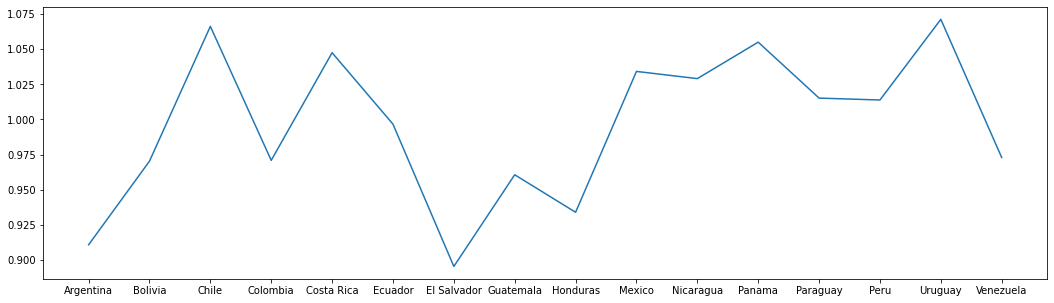

In [202]:
orig_bycountry = test_data[test_data['test']==0].groupby('country')['conversion'].mean()
after_bycountry = test_data[test_data['test']==1].groupby('country')['conversion'].mean()
fig = plt.figure(figsize=(18,5))
plt.plot(after_bycountry/orig_bycountry)

In [198]:
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier(max_depth=5)
dtree.fit(X_train_trans, y_train)


DecisionTreeClassifier(max_depth=5)

In [199]:

from tabulate import tabulate
headers = ["name", "score"]
values = sorted(zip(X_train_trans, dtree.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))

name                          score
country_Uruguay         0.395941
country_Peru            0.174418
country_Mexico          0.158729
country_Colombia        0.130283
country_Venezuela       0.123568
user_id                 0.0115954
source_Direct           0.00114948
browser_language_ES     0.00101192
browser_Safari          0.000881015
conversion              0.000848695
age                     0.000751672
device_Web              0.000557095
browser_language_Other  0.000265376
source_SEO              0
browser_Chrome          0
browser_FireFox         0
browser_IE              0
browser_Iphone_App      0
browser_Opera           0
sex_M                   0
country_Bolivia         0
country_Chile           0
country_Costa Rica      0
country_Ecuador         0
country_El Salvador     0
country_Guatemala       0
country_Honduras        0
country_Nicaragua       0
country_Panama          0
country_Paraguay        0


[Text(579.4615384615385, 298.98, 'X[28] <= 0.5\ngini = 0.497\nsamples = 401085\nvalue = [185311, 215774]'),
 Text(309.04615384615386, 244.62, 'X[23] <= 0.5\ngini = 0.498\nsamples = 396951\nvalue = [184896, 212055]'),
 Text(154.52307692307693, 190.26000000000002, 'X[17] <= 0.5\ngini = 0.495\nsamples = 268467\nvalue = [120687, 147780]'),
 Text(77.26153846153846, 135.9, 'X[29] <= 0.5\ngini = 0.492\nsamples = 214407\nvalue = [93599, 120808]'),
 Text(38.63076923076923, 81.53999999999999, 'X[27] <= 0.5\ngini = 0.489\nsamples = 182353\nvalue = [77450, 104903]'),
 Text(19.315384615384616, 27.180000000000007, 'gini = 0.483\nsamples = 148687\nvalue = [60581, 88106]'),
 Text(57.94615384615385, 27.180000000000007, 'gini = 0.5\nsamples = 33666\nvalue = [16869, 16797]'),
 Text(115.8923076923077, 81.53999999999999, 'X[13] <= 0.5\ngini = 0.5\nsamples = 32054\nvalue = [16149, 15905]'),
 Text(96.57692307692308, 27.180000000000007, 'gini = 0.5\nsamples = 29087\nvalue = [14597, 14490]'),
 Text(135.2076923

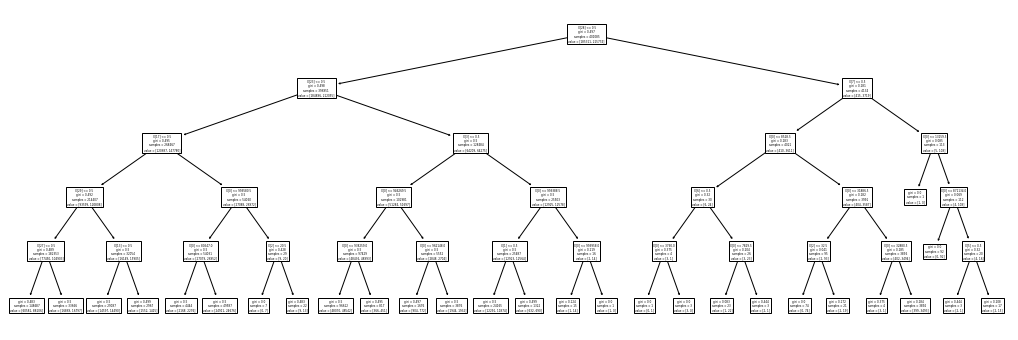

In [200]:
from sklearn.datasets import load_iris
from sklearn import tree
iris = load_iris()
fig = plt.figure(figsize=(18,6))
tree.plot_tree(dtree)

From the features, we can see that countries is the most important feature for conversion. So let’s check the test results
after controlling for country.

In [191]:
countries = [name for name in test_data['country'].unique() if name is not np.nan]

print('{0:15s} {1:>15s} {2:>15s} {3:>10s}'.format('Country', 'Test Rate', 'Control Rate', 'P-Value'))
print('-' * 65)
for country in countries:
    test_val = test_data[(test_data['country'] == country) & (test_data['test'] == 1)]['conversion'].values
    cont_val = test_data[(test_data['country'] == country) & (test_data['test'] == 0)]['conversion'].values
    
    test_mean = test_val.mean()
    cont_mean = cont_val.mean()
    p_val = ttest_ind(test_val, cont_val, equal_var=False).pvalue
    
    print('{0:15s} {1:15.5f} {2:15.5f} {3:10f}'.format(country, test_mean, cont_mean, p_val))

Country               Test Rate    Control Rate    P-Value
-----------------------------------------------------------------
Mexico                  0.05119         0.04949   0.165544
Venezuela               0.04898         0.05034   0.573702
Bolivia                 0.04790         0.04937   0.718885
Colombia                0.05057         0.05209   0.423719
Uruguay                 0.01291         0.01205   0.879764
El Salvador             0.04795         0.05355   0.248127
Nicaragua               0.05418         0.05265   0.780400
Peru                    0.05060         0.04991   0.771953
Costa Rica              0.05474         0.05226   0.687876
Chile                   0.05130         0.04811   0.302848
Argentina               0.01373         0.01507   0.335147
Ecuador                 0.04899         0.04915   0.961512
Guatemala               0.04865         0.05064   0.572107
Honduras                0.04754         0.05091   0.471463
Paraguay                0.04923         0.04849  

After we control for country, the test clearly appears non significant. Not a great success given that the
goal was to improve conversion rate, but at least we know that a localized translation didn’t make things
worse!